# TBD Phase 2: Performance & Computing Models

## Introduction
In this lab, you will compare the performance and computing models of four popular data processing engines: **Polars, Pandas, DuckDB, and PySpark**.

You will explore:
- **Performance**: Single-node processing speed, parallel execution, and memory usage.
- **Scalability**: How performance changes with the number of cores (single-node) and executors (cluster).
- **Computing Models**: Out-of-core vs. In-memory processing, and Eager vs. Lazy execution.

### Engine Capabilities
The following table summarizes the key capabilities of the engines we will be testing. Use this as a reference.

| Engine | Query Optimizer | Distributed | Arrow-backed | Out-of-Core | Parallel | APIs | GPU Support |
|---|---|---|---|---|--|---|---|
| **Pandas** | ❌ | ❌ | optional ≥ 2.0 | ❌ | ❌ | DataFrame | ❌ |
| **Polars** | ✅ | ❌ | ✅ | ✅ | ✅ | DataFrame | ✅ (opt) |
| **PySpark** | ✅ | ✅ | Pandas UDF/IO | ✅ | ✅ | SQL, DataFrame | ❌ (no GPU) |
| **DuckDB** | ✅ | ❌ | ✅ | ✅ | ❌ | SQL, Relational API | ❌ |

## Prerequisites
Ensure you have the necessary libraries installed.

In [ ]:
%pip install polars pandas duckdb pyspark faker deltalake memory_profiler pyarrow matplotlib

<a id="prerequisites"></a>
If you jumped here from the Polars scalability test instructions, run the cell below to load the required libraries and proceed to the next step.

[Polars: jump to step 3](#general-functions)

In [2]:
# (POLARS SCALABILITY STEP 2)
import polars as pl
import pandas as pd
import duckdb
from pyspark.sql import SparkSession
from faker import Faker
import numpy as np
import os
import time
import psutil
from memory_profiler import memory_usage

import matplotlib.pyplot as plt
import json
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Initialize Spark (Single Node)
spark = SparkSession.builder \
    .appName("BigDataLab2") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/04 14:48:41 WARN Utils: Your hostname, maczek.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.32 instead (on interface en0)
26/01/04 14:48:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/04 14:48:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Part 1: Data Generation

We will generate a synthetic dataset simulating social media posts with a rich schema.

**Schema**:
- `post_id` (String): Unique identifier.
- `user_id` (Integer): User identifier.
- `timestamp` (DateTime): Time of post.
- `content` (String): Text content.
- `likes` (Integer): Number of likes.
- `views` (Integer): Number of views.
- `category` (String): Post category.
- `tags` (List[String]): Hashtags.
- `location` (String): User location.
- `device` (String): Device used (Mobile, Web, etc.).
- `latency` (Float): Network latency.
- `error_rate` (Float): Error rate during upload.

In [2]:
def generate_data(num_records=1_000_000, output_path="social_media_data.parquet"):
    fake = Faker()
    
    print(f"Generating {num_records} records...")
    
    # Generate data using numpy for speed where possible
    data = {
        "post_id": [fake.uuid4() for _ in range(num_records)],
        "user_id": np.random.randint(1, 100_000, num_records),
        "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="s").to_numpy().astype("datetime64[us]"),
        "likes": np.random.randint(0, 10_000, num_records),
        "views": np.random.randint(0, 1_000_000, num_records),
        "category": np.random.choice(["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"], num_records),
        "tags": [np.random.choice(["#viral", "#new", "#trending", "#hot", "#update"], size=np.random.randint(1, 4)).tolist() for _ in range(num_records)],
        "location": np.random.choice(["USA", "UK", "DE", "PL", "FR", "JP", "BR"], num_records),
        "device": np.random.choice(["Mobile", "Desktop", "Tablet"], num_records),
        "latency": np.random.uniform(10.0, 500.0, num_records),
        "error_rate": np.random.beta(1, 10, num_records),
        "content": [fake.sentence() for _ in range(min(num_records, 1000))] * (num_records // 1000 + 1)
    }
    
    # Trim to exact size
    data["content"] = data["content"][:num_records]
    
    df = pd.DataFrame(data)
    
    print("Writing to Parquet...")
    df.to_parquet(output_path, engine="pyarrow")
    print(f"Data saved to {output_path}")

# Generate 5 million records
generate_data(num_records=5_000_000)

Generating 5000000 records...
Writing to Parquet...
Data saved to social_media_data.parquet


## Part 2: Measuring Performance

### 2.1 Execution Time
Use `%time` or `%timeit` to measure execution time.

In [3]:
# Example: Measuring time for all engines
print("--- Performance Benchmark Example ---")

# Pandas
print("Pandas Load Time:")
%time df_pd = pd.read_parquet("social_media_data.parquet")

# Polars
print("\nPolars Load Time:")
%time df_pl = pl.read_parquet("social_media_data.parquet")

# DuckDB
print("\nDuckDB Query Time:")
%time duckdb.sql("SELECT count(*) FROM 'social_media_data.parquet'").show()

# PySpark
print("\nSpark Load Time:")
%time df_spark = spark.read.parquet("social_media_data.parquet"); df_spark.count()

--- Performance Benchmark Example ---
Pandas Load Time:
CPU times: user 2.77 s, sys: 1.02 s, total: 3.79 s
Wall time: 2.96 s

Polars Load Time:
CPU times: user 527 ms, sys: 245 ms, total: 772 ms
Wall time: 356 ms

DuckDB Query Time:
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      5000000 │
└──────────────┘

CPU times: user 1.66 ms, sys: 11.7 ms, total: 13.3 ms
Wall time: 54.9 ms

Spark Load Time:


CPU times: user 3.99 ms, sys: 4.65 ms, total: 8.64 ms
Wall time: 2.42 s


5000000

## Part 3: Student Tasks

### Task 1: Performance & Scalability (Single Node)

**Goal**: Benchmark the engines and test how they scale with available CPU cores.

**Instructions**:
1.  **Define Queries**: Create 3 distinct queries of your own choice. They should cover:
    -   **Query A**: A simple aggregation (e.g., grouping by a categorical column and calculating means).
    -   **Query B**: A window function or more complex transformation.
    -   **Query C**: A join (e.g., self-join or join with a smaller generated table) with filtering.
2.  **Benchmark**: Implement these queries in **Pandas, Polars, DuckDB, and PySpark**.
    -   Measure **Execution Time** using `%time` or `time.time()`.
    -   Measure **Peak Memory** usage using `memory_profiler` (e.g., `memory_usage()`).
3.  **Scalability Test**: 
    -   Select **all engines** that support parallel execution on a single node (e.g., Polars, DuckDB).
    -   Run **all 3 queries** with different numbers of threads/cores (e.g., 1, 2, 4, 8).
    -   Plot the speedup for each query and engine.

**Tip**: 
-   Polars: [polars.thread_pool_size](https://docs.pola.rs/api/python/stable/reference/api/polars.thread_pool_size.html) Please also note that *Thread configuration in Polars requires process restart*
-   DuckDB: `PRAGMA threads=n`
-   Spark: `master="local[n]"`

#### 3.1.1: General Functions for Benchmarking
If you jumped here from the Polars scalability test instructions, run the cell below to load the general functions needed for benchmarking and proceed to the next step.

<a id="general-functions"></a>
[Polars: jump to step 4](#polars-scalability)

In [3]:
# (POLARS STEP 3)
# Query definitions
def define_queries():
    """Define 3 distinct queries for benchmarking"""

    queries = {
        "A": {
            "pandas": lambda df: df.groupby("category").agg({"likes": "mean", "views": "sum"}),
            "polars": lambda df: df.group_by("category").agg([
                pl.col("likes").mean().alias("avg_likes"),
                pl.col("views").sum().alias("total_views")
            ]),
            "duckdb": lambda: duckdb.sql("""
                SELECT category, AVG(likes) as avg_likes, SUM(views) as total_views
                FROM "social_media_data.parquet"
                GROUP BY category
            """).df(),
            "spark": lambda df: df.groupBy("category").agg(
                F.avg("likes").alias("avg_likes"),
                F.sum("views").alias("total_views")
            ).toPandas()
        },

        "B": {
            "pandas": lambda df: (
                df.assign(rank=df.groupby("location")["likes"].rank(method="dense", ascending=False))
                .loc[lambda x: x["rank"] <= 100]
                .sort_values(["location", "rank"])
            ),
            "polars": lambda df: (
                df.with_columns(
                    pl.col("likes").rank("dense", descending=True).over("location").alias("rank")
                )
                .filter(pl.col("rank") <= 100)
                .sort(["location", "rank"])
            ),
            "duckdb": lambda: duckdb.sql("""
                WITH ranked AS (
                    SELECT *, DENSE_RANK() OVER (PARTITION BY location ORDER BY likes DESC) as rank
                    FROM "social_media_data.parquet"
                )
                SELECT * FROM ranked 
                WHERE rank <= 100
                ORDER BY location, rank
            """).df(),
            "spark": lambda df: (
                df.withColumn(
                    "rank",
                    F.dense_rank().over(Window.partitionBy("location").orderBy(F.col("likes").desc()))
                )
                .filter(F.col("rank") <= 100)
                .orderBy("location", "rank")
                .toPandas()
            )
        },

        "C": {
            "pandas": lambda df: (
                df[df["likes"] > 5000]
                .merge(
                    df.groupby("user_id")["likes"].sum().reset_index().rename(columns={"likes": "total_user_likes"}),
                    on="user_id"
                )
                .sort_values("total_user_likes", ascending=False)
                .head(1000)
            ),
            "polars": lambda df: (
                df.filter(pl.col("likes") > 5000)
                .join(
                    df.group_by("user_id").agg(pl.col("likes").sum().alias("total_user_likes")),
                    on="user_id"
                )
                .sort("total_user_likes", descending=True)
                .head(1000)
            ),
            "duckdb": lambda: duckdb.sql("""
                WITH user_totals AS (
                    SELECT user_id, SUM(likes) as total_user_likes
                    FROM "social_media_data.parquet"
                    GROUP BY user_id
                )
                SELECT p.*, u.total_user_likes
                FROM "social_media_data.parquet" p
                JOIN user_totals u ON p.user_id = u.user_id
                WHERE p.likes > 5000
                ORDER BY u.total_user_likes DESC
                LIMIT 1000
            """).df(),
            "spark": lambda df: (
                df.filter(F.col("likes") > 5000)
                .join(
                    df.groupBy("user_id").agg(F.sum("likes").alias("total_user_likes")),
                    on="user_id"
                )
                .orderBy(F.col("total_user_likes").desc())
                .limit(1000)
                .toPandas()
            )
        }
    }
    return queries

def benchmark_query(query_func, df=None):
    """Measure execution time and peak memory"""

    def execute():
        return query_func(df) if df is not None else query_func()

    start = time.time()
    mem_usage = memory_usage((execute,), max_usage=True)
    elapsed = time.time() - start

    return elapsed, mem_usage

def save_results(results, filename="scalability_results.json"):
    """Save results to JSON file"""
    with open(filename, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {filename}")

def load_results(filename="scalability_results.json"):
    """Load results from JSON file"""
    if os.path.exists(filename):
        with open(filename, "r") as f:
            return json.load(f)
    return {}


queries = define_queries()
queries_list = ["A", "B", "C"]
engines_list = ["pandas", "duckdb", "polars", "spark"]
thread_counts = [1, 2, 4, 8]

print("Loading data...")
df_pd = pd.read_parquet("social_media_data.parquet")
df_pl = pl.read_parquet("social_media_data.parquet")
df_spark = spark.read.parquet("social_media_data.parquet")
df_spark.cache()
print("Data loaded")

df_map = {
    "pandas": df_pd,
    "polars": df_pl,
    "spark": df_spark,
    "duckdb": None
}

Loading data...


Data loaded


##### Visual verification of queries implementations

In [5]:
print("QUERY A: Aggregation by category")
print("-" * 50)
for engine in engines_list:
    print(f"{engine}:")
    if engine == "duckdb":
        result = queries["A"][engine]()
    else:
        result = queries["A"][engine](df_map[engine])
    print(result)
    print()

print()
print("="*70)
print()

print("QUERY B: Window function - top 100 posts per location")
print("-" * 50)
for engine in engines_list:
    print(f"{engine} (first 10 rows):")
    if engine == "duckdb":
        result = queries["B"][engine]()
    else:
        result = queries["B"][engine](df_map[engine])
    print(result.head(10))
    print()

print()
print("="*70)
print()

print("QUERY C: Join - popular posts from top users")
print("-" * 50)
for engine in engines_list:
    print(f"{engine} (first 10 rows):")
    if engine == "duckdb":
        result = queries["C"][engine]()
    else:
        result = queries["C"][engine](df_map[engine])
    print(result.head(10))
    print()

QUERY A: Aggregation by category
--------------------------------------------------
pandas:
                likes         views
category                           
Fashion   4995.725996  357207320636
Food      4990.028235  357571793551
Health    4996.981484  356522487519
Politics  5002.263264  357277676461
Sports    5003.851723  357080866165
Tech      4997.093933  357166662302
Travel    5000.165627  357837709247

duckdb:
   category    avg_likes   total_views
0   Fashion  4995.725996  3.572073e+11
1  Politics  5002.263264  3.572777e+11
2      Food  4990.028235  3.575718e+11
3      Tech  4997.093933  3.571667e+11
4    Sports  5003.851723  3.570809e+11
5    Travel  5000.165627  3.578377e+11
6    Health  4996.981484  3.565225e+11

polars:
shape: (7, 3)
┌──────────┬─────────────┬──────────────┐
│ category ┆ avg_likes   ┆ total_views  │
│ ---      ┆ ---         ┆ ---          │
│ str      ┆ f64         ┆ i64          │
╞══════════╪═════════════╪══════════════╡
│ Food     ┆ 4990.028235 ┆ 357

   category    avg_likes   total_views
0      Food  4990.028235  357571793551
1   Fashion  4995.725996  357207320636
2    Sports  5003.851723  357080866165
3    Travel  5000.165627  357837709247
4    Health  4996.981484  356522487519
5      Tech  4997.093933  357166662302
6  Politics  5002.263264  357277676461



QUERY B: Window function - top 100 posts per location
--------------------------------------------------
pandas (first 10 rows):
                                     post_id  user_id           timestamp  \
21257   9a603bb7-622e-47eb-bcf9-03ae84c910c7    65922 2023-01-01 05:54:17   
51235   4a4722b8-b61f-4193-8d7a-f9d3a3278f18    12384 2023-01-01 14:13:55   
129457  3415fa5d-18c4-4ef4-94b1-08685b7511a1    55445 2023-01-02 11:57:37   
176988  fe8bd2f2-5597-42e8-9671-c741c44021fa    63854 2023-01-03 01:09:48   
228988  1f4e9a18-cf48-4334-bb50-04592a01713c    70834 2023-01-03 15:36:28   
231484  f148dd67-91de-410e-8342-cb0a3671710b    30536 2023-01-03 16:18:04   
303311  c2c17b2d-

                                post_id  user_id           timestamp  likes  \
0  9a603bb7-622e-47eb-bcf9-03ae84c910c7    65922 2023-01-01 05:54:17   9999   
1  4a4722b8-b61f-4193-8d7a-f9d3a3278f18    12384 2023-01-01 14:13:55   9999   
2  3415fa5d-18c4-4ef4-94b1-08685b7511a1    55445 2023-01-02 11:57:37   9999   
3  fe8bd2f2-5597-42e8-9671-c741c44021fa    63854 2023-01-03 01:09:48   9999   
4  1f4e9a18-cf48-4334-bb50-04592a01713c    70834 2023-01-03 15:36:28   9999   
5  f148dd67-91de-410e-8342-cb0a3671710b    30536 2023-01-03 16:18:04   9999   
6  c2c17b2d-c9e7-4294-bac0-5c92ff5b49db     5881 2023-01-04 12:15:11   9999   
7  cbe0dc5a-9dd6-4338-bef7-95842b5ecac4    57969 2023-01-05 01:13:03   9999   
8  555cdacf-c91f-49f4-8990-9ae42c0a5a9e    83286 2023-01-05 01:14:39   9999   
9  2e5c51ef-d40d-4390-affc-5f70550a7053    76862 2023-01-05 13:05:04   9999   

    views  category                          tags location   device  \
0  218984      Food               [#update, #new]       BR 

   user_id                               post_id           timestamp  likes  \
0    62673  1d55bb15-663b-4606-9ff5-a3b875cde9f0 2023-01-01 22:25:54   5979   
1    62673  8474d7ff-208b-4877-9a58-1b39d8f7294b 2023-01-04 02:08:55   8857   
2    62673  3cd57ee6-8c04-4945-96ff-00020d87ac50 2023-01-04 09:52:14   8551   
3    62673  9a1c3c2d-8e22-43d1-ab7e-4c8fa45a1b80 2023-01-04 20:19:07   6819   
4    62673  51e4f355-06e3-4364-ac50-775d1beb285c 2023-01-05 14:35:25   9318   
5    62673  c997621c-f817-413d-94d8-3626ec715d8b 2023-01-05 22:11:22   9554   
6    62673  cb1a3c2e-da0f-42f1-9c18-f66ba96f6b8c 2023-01-08 08:14:56   9696   
7    62673  6e34d59a-1106-4e21-9cee-7ed839819356 2023-01-08 11:57:29   9633   
8    62673  572fd34d-9060-41f6-b625-fdd17a1470f1 2023-01-09 23:56:43   9466   
9    62673  d9c7f89f-e70d-4741-b747-b924a1cb23fa 2023-01-10 17:53:35   9050   

    views category                       tags location   device     latency  \
0  100796  Fashion                  [#update]      

#### 3.1.2: Benchmarks for Pandas, DuckDB, Polars and PySpark

=== Running Benchmarks ===
Query A:
  pandas:	1.888s, 255.0MB
  duckdb:	0.767s, 269.7MB
  polars:	1.342s, 424.8MB
  spark:	0.864s, 425.1MB

Query B:
  pandas:	13.401s, 1706.5MB
  duckdb:	2.370s, 1641.0MB
  polars:	1.488s, 1638.1MB


  spark:	8.146s, 786.8MB

Query C:
  pandas:	5.788s, 1769.6MB
  duckdb:	0.782s, 1651.8MB
  polars:	5.808s, 1592.6MB


  spark:	9.584s, 584.9MB



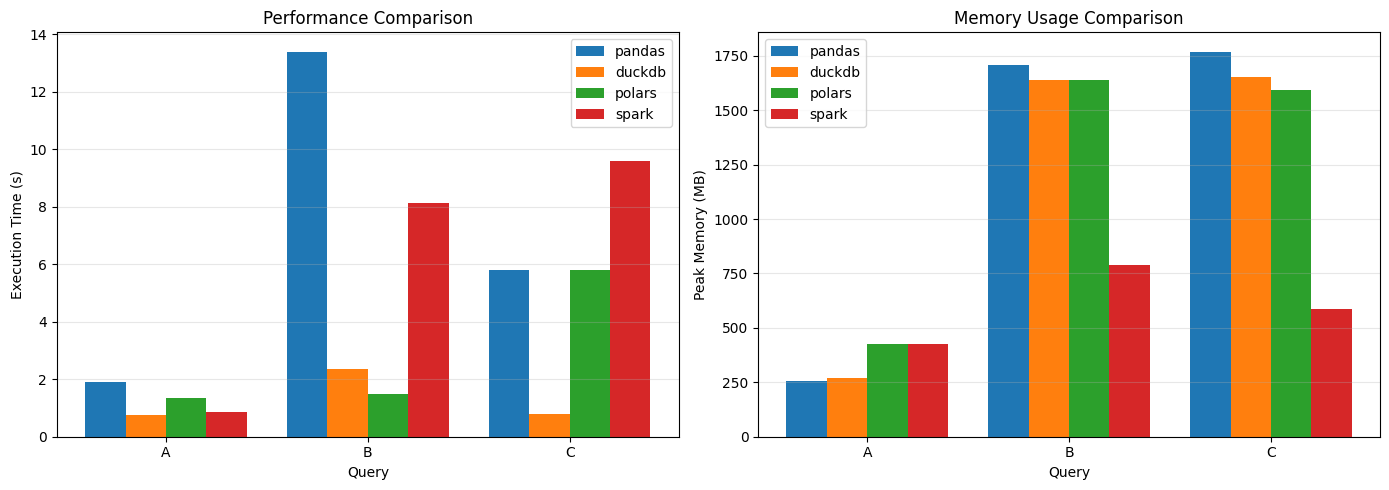

=== Summary ===
Fastest engine per query:
  Query A: duckdb (0.767s)
  Query B: polars (1.488s)
  Query C: duckdb (0.782s)

Least memory intensive engine per query:
  Query A: pandas (255.0MB)
  Query B: spark (786.8MB)
  Query C: spark (584.9MB)


In [6]:
results = {
    engine: {
        query: {
            "time": 0,
            "memory": 0
        } for query in queries_list
    } for engine in engines_list
}

print("=== Running Benchmarks ===")
for query_name in queries_list:
    print(f"Query {query_name}:")

    for engine in engines_list:
        query_func = queries[query_name][engine]

        elapsed, mem = benchmark_query(query_func, df_map[engine])
        results[engine][query_name]["time"] = elapsed
        results[engine][query_name]["memory"] = mem

        print(f"  {engine}:\t{elapsed:.3f}s, {mem:.1f}MB")
    print()


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(queries_list))
width = 0.2

# Performance comparison
ax1 = axes[0]
for i, engine in enumerate(engines_list):
    times = [results[engine][q]["time"] for q in queries_list]
    ax1.bar(x + i*width, times, width, label=engine)

ax1.set_xlabel("Query")
ax1.set_ylabel("Execution Time (s)")
ax1.set_title("Performance Comparison")
ax1.set_xticks(x + width*1.5)
ax1.set_xticklabels(queries_list)
ax1.legend()
ax1.grid(axis="y", alpha=0.3)

# Memory comparison
ax2 = axes[1]
for i, engine in enumerate(engines_list):
    mems = [results[engine][q]["memory"] for q in queries_list]
    ax2.bar(x + i*width, mems, width, label=engine)

ax2.set_xlabel("Query")
ax2.set_ylabel("Peak Memory (MB)")
ax2.set_title("Memory Usage Comparison")
ax2.set_xticks(x + width*1.5)
ax2.set_xticklabels(queries_list)
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Summary ===")
print("Fastest engine per query:")
for query_name in queries_list:
    times = {eng: results[eng][query_name]["time"] for eng in engines_list}
    fastest = min(times, key=times.get)
    print(f"  Query {query_name}: {fastest} ({times[fastest]:.3f}s)")

print()
print("Least memory intensive engine per query:")
for query_name in queries_list:
    mems = {eng: results[eng][query_name]["memory"] for eng in engines_list}
    smallest = min(mems, key=mems.get)
    print(f"  Query {query_name}: {smallest} ({mems[smallest]:.1f}MB)")

#### 3.1.3: Scalability Tests

##### 3.1.3.1: DuckDB Scalability Test

In [7]:
# Scalability Test - DuckDB
print("=== DuckDB Scalability Test ===")
scalability_results = load_results()
scalability_results["duckdb"] = {q: [] for q in queries_list}

for threads in thread_counts:
    print(f"DuckDB with {threads} threads:")
    duckdb.execute(f"PRAGMA threads={threads}")

    for query_name in queries_list:
        query_func = queries[query_name]["duckdb"]
        elapsed, _ = benchmark_query(query_func, None)
        scalability_results["duckdb"][query_name].append(elapsed)
        print(f"  Query {query_name}: {elapsed:.3f}s")
    print()

save_results(scalability_results)

=== DuckDB Scalability Test ===
DuckDB with 1 threads:
  Query A: 0.828s
  Query B: 5.040s
  Query C: 1.046s

DuckDB with 2 threads:
  Query A: 0.669s
  Query B: 3.173s
  Query C: 0.757s

DuckDB with 4 threads:
  Query A: 0.639s
  Query B: 2.311s
  Query C: 0.640s

DuckDB with 8 threads:
  Query A: 0.619s
  Query B: 1.887s
  Query C: 0.555s

Results saved to scalability_results.json


##### 3.1.3.2: PySpark Scalability Test

In [8]:
print("=== Spark Scalability Test ===")
scalability_results = load_results()
scalability_results["spark"] = {q: [] for q in queries_list}
spark.stop()

for executors in thread_counts:
    print(f"Spark with local[{executors}]:")

    spark_test = SparkSession.builder \
        .appName("ScalabilityTest") \
        .master(f"local[{executors}]") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    df_spark_test = spark_test.read.parquet("social_media_data.parquet")
    df_spark_test.cache()
    df_spark_test.count()

    for query_name in queries_list:
        query_func = queries[query_name]["spark"]
        elapsed, _ = benchmark_query(query_func, df_spark_test)
        scalability_results["spark"][query_name].append(elapsed)
        print(f"  Query {query_name}: {elapsed:.3f}s")

    spark_test.stop()
    print()

# Restart original Spark session
spark = SparkSession.builder \
    .appName("BigDataLab2") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

save_results(scalability_results)

=== Spark Scalability Test ===
Spark with local[1]:


  Query A: 1.145s


  Query B: 8.674s


  Query C: 6.472s

Spark with local[2]:


  Query A: 0.977s


  Query B: 6.939s


  Query C: 5.703s

Spark with local[4]:


  Query A: 1.031s


  Query B: 7.049s


  Query C: 4.397s

Spark with local[8]:


  Query A: 1.439s


  Query B: 4.673s


  Query C: 4.956s

Results saved to scalability_results.json


##### 3.1.3.3: Polars Scalability Test

Testing scalability of Polars with different thread counts requires restarting the kernel each time the thread pool size is changed. This is a cumbersome process, so we provide short instructions below, as well as links to jump between the required steps (work 50% of the time so we added comments "(POLARS STEP X)" at the beginning of the relevant cells).

- Step 0: Restart the kernel
- Step 1: Set the desired thread pool size
- Step 2: Load the libraries
- Step 3: Load the general functions
- Step 4: Run the Polars scalability test code

This the first step - **restart the kernel now**, uncomment the chosen thread pool size line, and run the cell and proceed to the next step.

[Polars: jump to step 2](#prerequisites)

In [1]:
# (POLARS STEP 1)
import os

# Set desired thread count (uncomment one line)
# THREAD_COUNT = 1
# THREAD_COUNT = 2
# THREAD_COUNT = 4
THREAD_COUNT = 8

os.environ["POLARS_MAX_THREADS"] = str(THREAD_COUNT)

print(f"Set POLARS_MAX_THREADS to {THREAD_COUNT}")

Set POLARS_MAX_THREADS to 8


<a id="polars-scalability"></a>
This is the fourth and final step - run the Polars scalability test code below.

If you wish to test another thread pool size, please go back to first step (cell above) and repeat the process.

In [4]:
# (POLARS STEP 4)
# To perform multiple tests refer to the instructions above

print("=== Polars Scalability Test ===")
current_threads = pl.thread_pool_size()
print(f"Current Polars thread count: {current_threads}")

scalability_results = load_results()

if "polars" not in scalability_results:
    scalability_results["polars"] = {q: {} for q in queries_list}

df_pl = pl.read_parquet("social_media_data.parquet")

for query_name in queries_list:
    query_func = queries[query_name]["polars"]
    elapsed, _ = benchmark_query(query_func, df_pl)
    scalability_results["polars"][query_name][str(current_threads)] = elapsed
    print(f"Query {query_name}: {elapsed:.3f}s")

save_results(scalability_results)
print()
print(f"Results saved for {current_threads} threads")
print("To test with different thread count refer to the instructions in the cell above")

=== Polars Scalability Test ===
Current Polars thread count: 8
Query A: 1.017s
Query B: 0.872s
Query C: 1.919s
Results saved to scalability_results.json

Results saved for 8 threads
To test with different thread count refer to the instructions in the cell above


##### 3.1.3.4: Scalability Test Results Visualization

=== Plotting Scalability Test Results ===


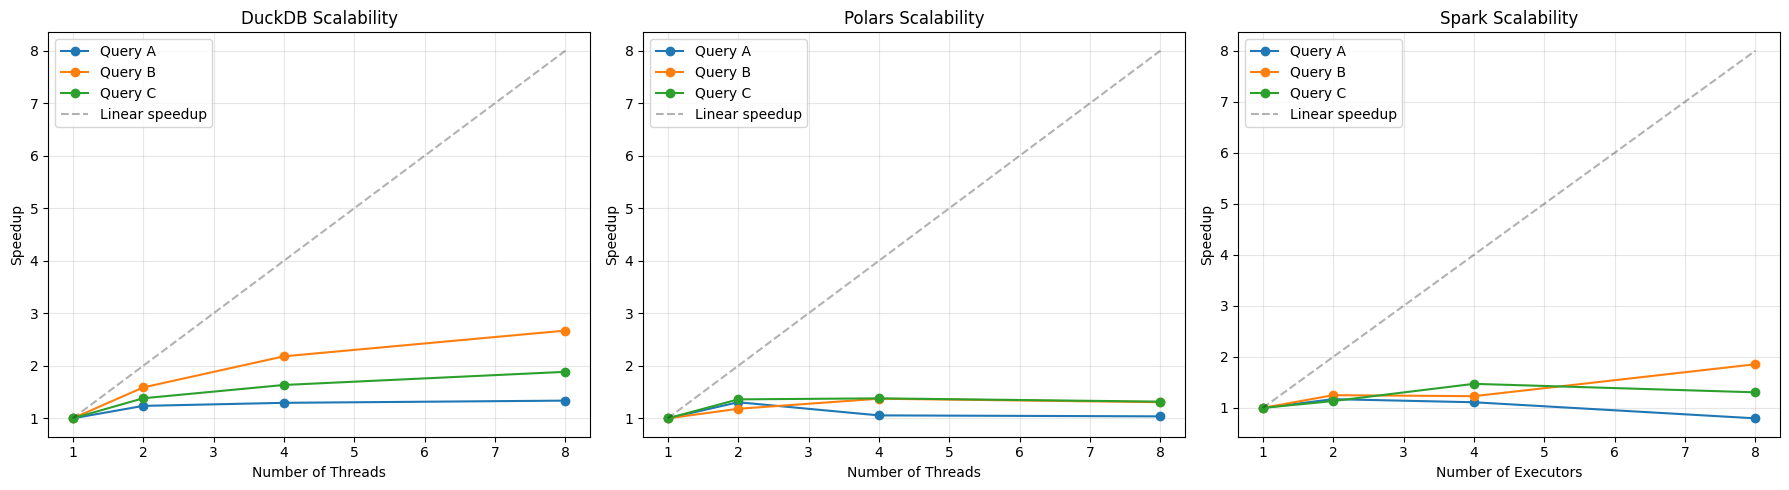

=== Scalability Test Summary ===
Query A:
Engine: duckdb
	Threads	1	2	4	8
	Times	0.828	0.669	0.639	0.619
	Speedup	1.000	1.237	1.295	1.337
Engine: polars
	Threads	1	2	4	8
	Times	1.055	0.808	0.999	1.017
	Speedup	1.000	1.306	1.056	1.038
Engine: spark
	Threads	1	2	4	8
	Times	1.145	0.977	1.031	1.439
	Speedup	1.000	1.172	1.111	0.796

Query B:
Engine: duckdb
	Threads	1	2	4	8
	Times	5.040	3.173	2.311	1.887
	Speedup	1.000	1.588	2.181	2.671
Engine: polars
	Threads	1	2	4	8
	Times	1.140	0.964	0.830	0.872
	Speedup	1.000	1.182	1.374	1.307
Engine: spark
	Threads	1	2	4	8
	Times	8.674	6.939	7.049	4.673
	Speedup	1.000	1.250	1.231	1.856

Query C:
Engine: duckdb
	Threads	1	2	4	8
	Times	1.046	0.757	0.640	0.555
	Speedup	1.000	1.382	1.635	1.886
Engine: polars
	Threads	1	2	4	8
	Times	2.529	1.858	1.832	1.919
	Speedup	1.000	1.361	1.381	1.318
Engine: spark
	Threads	1	2	4	8
	Times	6.472	5.703	4.397	4.956
	Speedup	1.000	1.135	1.472	1.306



In [5]:
# Final Visualization - Scalability Results
print("=== Plotting Scalability Test Results ===")
scalability_results = load_results()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# DuckDB
if "duckdb" in scalability_results:
    ax = axes[0]
    for query_name in queries_list:
        times = scalability_results["duckdb"][query_name]
        if times:
            speedup = [times[0]/t for t in times]
            ax.plot(thread_counts[:len(speedup)], speedup, marker="o", label=f"Query {query_name}")

    ax.plot(thread_counts, thread_counts, "k--", alpha=0.3, label="Linear speedup")
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel("Speedup")
    ax.set_title("DuckDB Scalability")
    ax.legend()
    ax.grid(alpha=0.3)

# Polars
if "polars" in scalability_results:
    ax = axes[1]
    for query_name in queries_list:
        results_dict = scalability_results["polars"][query_name]
        if results_dict:
            threads = sorted([int(k) for k in results_dict.keys()])
            times = [results_dict[str(t)] for t in threads]
            speedup = [times[0]/t for t in times]
            ax.plot(threads, speedup, marker="o", label=f"Query {query_name}")

    ax.plot(thread_counts, thread_counts, "k--", alpha=0.3, label="Linear speedup")
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel("Speedup")
    ax.set_title("Polars Scalability")
    ax.legend()
    ax.grid(alpha=0.3)

# Spark
if "spark" in scalability_results:
    ax = axes[2]
    for query_name in queries_list:
        times = scalability_results["spark"][query_name]
        if times:
            speedup = [times[0]/t for t in times]
            ax.plot(thread_counts[:len(speedup)], speedup, marker="o", label=f"Query {query_name}")

    ax.plot(thread_counts, thread_counts, "k--", alpha=0.3, label="Linear speedup")
    ax.set_xlabel("Number of Executors")
    ax.set_ylabel("Speedup")
    ax.set_title("Spark Scalability")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Scalability Test Summary ===")

for query_name in queries_list:
    print(f"Query {query_name}:")
    for engine in ["duckdb", "polars", "spark"]:
        print(f"Engine: {engine}")
        if engine == "polars":
            threads = sorted([int(k) for k in results_dict.keys()])
            print("\tThreads", end="")
            for th in threads:
                print(f"\t{th}", end="")
            print()
            print("\tTimes", end="")
            for th in threads:
                print(f"\t{scalability_results[engine][query_name][str(th)]:.3f}", end="")
            print()
            print("\tSpeedup", end="")
            for th in threads:
                speedup = scalability_results[engine][query_name][str(threads[0])] / scalability_results[engine][query_name][str(th)]
                print(f"\t{speedup:.3f}", end="")
            print()
        else:
            print("\tThreads", end="")
            for th in thread_counts:
                print(f"\t{th}", end="")
            print()
            print("\tTimes", end="")
            for i, _ in enumerate(thread_counts):
                print(f"\t{scalability_results[engine][query_name][i]:.3f}", end="")
            print()
            print("\tSpeedup", end="")
            for i, _ in enumerate(thread_counts):
                speedup = scalability_results[engine][query_name][0] / scalability_results[engine][query_name][i]
                print(f"\t{speedup:.3f}", end="")
            print()
    print()

### Task 2: Spark on Cluster

**Goal**: Compare Single Node performance vs. Spark on a Cluster.

**Instructions**:
1.  **Infrastructure**: Use the infrastructure from **Phase 1** (Google Dataproc). You may need to modify your Terraform code to adjust the cluster configuration (e.g., number of worker nodes).
2.  **Environment**: The easiest way to run this is via **Google Workbench** connected to your Dataproc cluster.
3.  **Upload Data**: Upload the generated `social_media_data.parquet` to HDFS or GCS.
    -   **Tip**: For better performance, consider **partitioning** the data (e.g., by `category` or `date`) when saving it to the distributed storage. This allows Spark to optimize reads.
4.  **Run Queries**: Run your PySpark queries from Task 1 on the cluster.
5.  **Scalability Test**: 
    -   Run the queries with different numbers of **worker nodes** (e.g., 2, 3, 4).
    -   You can achieve this by resizing the cluster (manually or via Terraform) or by configuring the number of executors in Spark.
6.  **Analyze**:
    -   How does the cluster performance compare to your local machine?
    -   Did adding more nodes/executors linearly improve performance?
    -   **Tip**: If Spark is slower than single-node engines, consider **increasing the dataset size** (e.g., generate 10M+ records or duplicate the data). Spark's overhead is significant for small data, and its true power appears when data exceeds single-node memory.

In [ ]:
# Your Code Here for Task 2

### Task 3: Execution Modes & Analysis

**Goal**: Deep dive into execution models and limitations.

**Instructions**:
1.  **Lazy vs. Eager vs. Streaming**:
    -   Use **Polars**. Compare the **Execution Time** and **Peak Memory** of:
        -   Eager execution (`read_parquet` -> filter).
        -   Lazy execution (`scan_parquet` -> filter -> `collect()`).
        -   Streaming execution (`scan_parquet` -> filter -> `collect(streaming=True)`).
2.  **Polars Limitations**:
    -   Identify a scenario where Polars might struggle compared to Spark (e.g., memory limits).
3.  **Decision Boundary**:
    -   Based on your findings, when would you recommend switching from a single-node tool (Polars/DuckDB) to a distributed engine (Spark)?

In [ ]:
# Your Code Here for Task 3